In [1]:
from ROOT import TCanvas, TFile
from ROOT import TGraph, TGraphPolar
from ROOT import gStyle
from array import array
import math

c1 = TCanvas( 'c1', 'The Main Canvas', 200, 10, 1000, 800 )
c1.SetGridx()
c1.SetGridy()
c1.GetFrame().SetFillColor( 21 )
c1.GetFrame().SetBorderMode(-1 )
c1.GetFrame().SetBorderSize( 5 )
c1.Divide(1,1)

Welcome to JupyROOT 6.18/00


In [2]:
def fderiv(y,t,param,deriv):
    a = param[0]
    deriv[0] = a*math.pow(math.sin(t),2)*y[0]

In [3]:
def yexact(t,param):
    return 2*param[0]*math.exp(0.5*(t - math.sin(t)*math.cos(t)))

In [4]:
def rk2(y,nY,t,tau,deriv,param):
    F1 = array('d')
    F2 = array('d')
    ytemp = array('d')
    
    for i in range(0,nY):
        F1.append(0.0)
        F2.append(0.0)
        ytemp.append(0.0)
    
    fderiv(y,t,param,F1)
    
    half_tau = 0.5*tau
    t_half = t + half_tau
    
    for i in range(0,nY):
        ytemp[i]=y[i]+half_tau*F1[i]
        
    fderiv(ytemp,t_half,param,F2)
        
    for i in range(0,nY):
        y[i] = y[i] + tau*F2[i]

In [5]:
def rk4(y,nY,t,tau,deriv,param):
    F1 = array('d')
    F2 = array('d')
    F3 = array('d')
    F4 = array('d')
    ytemp = array('d')
    
    for i in range(0,nY):
        F1.append(0.0)
        F2.append(0.0)
        F3.append(0.0)
        F4.append(0.0)
        ytemp.append(0.0)
        
    fderiv(y,t,param,F1)
    
    half_tau = 0.5*tau
    t_half = t + half_tau
    
    for i in range(0,nY):
        ytemp[i] = y[i] + half_tau*F1[i]
        
    fderiv(ytemp,t_half,param,F2)
    
    for i in range(0,nY):
        ytemp[i] = y[i] + half_tau*F2[i]
        
    fderiv(ytemp,t_half,param,F3)
    
    t_full = t + tau

    for i in range(0,nY):
        ytemp[i] = y[i] + tau*F3[i]
        
    fderiv(ytemp,t_full,param,F4)
    
    for i in range(0,nY):
        y[i] = y[i] + tau/6.0*(F1[i]+F4[i]+2.0*(F2[i]+F3[i]))

In [6]:
def rka(x,nX,t,tau,err,deriv,param):
    tSave = t
    safe1 = 0.9
    safe2 = 0.2
    
    xSmall = array('d')
    xBig = array('d')
    for i in range(0,nX):
        xSmall.append(0.0)
        xBig.append(0.0)
        
    maxTry = 100
    for iTry in range(0,maxTry):
        half_tau = 0.5*tau
        for i in range(0,nX):
            xSmall[i]=x[i]
        rk4(xSmall,nX,tSave,half_tau,deriv,param)
        t = tSave + half_tau
        rk4(xSmall,nX,t,half_tau,deriv,param)
        
        t = tSave + tau
        for i in range(0,nX):
            xBig[i] = x[i]
        rk4(xBig,nX,tSave,tau,deriv,param)
        
        errorRatio = 0.0
        eps = 1.0E-16
        for i in range(0,nX):
            scale = err * (math.fabs(xSmall[i]) + math.fabs(xBig[i]))/2.0
            xDiff = xSmall[i]-xBig[i]
            ratio = math.fabs(xDiff)/(scale+eps)
            if (errorRatio <= ratio):
                errorRatio = ratio
                
        tau_old = tau
        tau = safe1*tau_old*math.pow(errorRatio,-0.20)
        if (tau <= tau_old/safe2):
            tau = tau_old/safe2
        if (tau >= safe2/tau_old):
            tau = safe2/tau_old
            
        if (errorRatio < 1):
            for i in range(0,nX):
                x[i] = xSmall[i]
            return
        
    print("Error:  Adaptive Runge-Kutta Routine failed")

In [7]:
# Wikipedia page y' = (sin(t))^2*y

nStep = 11
tau = 0.5


# Everything below this point is calculated.
y0 = 2.0
yp0 = 0.0

param = array('d')
param.append(1.0)
adaptErr = 0.001
time = 0.0

tlow = 0
thigh = tlow + (nStep-1)*tau
#print(tlow,thigh)
yy = array('d')
tt = array('d')
nexact = 1000
dt = (thigh-tlow)/nexact
for i in range(0,nexact+1):
    texact = tlow + i*dt
    yy.append(yexact(texact,param))
    tt.append(texact)
#print(yy,tt)

In [8]:
y = array('d')
state = array('d')
deriv = array('d')

nState = 1

y.append(y0)

state.append(y[0])

for i in range(0,nState):
    deriv.append(yp0)

In [9]:
yplot = array('d')
tplot = array('d')

In [10]:
for iStep in range(0,nStep):
    yplot.append(y[0])
    tplot.append(time)
    
    if (method == 1):
        fderiv(state,time,param,deriv)
        y[0] = y[0] + tau*deriv[0]
        time = time + tau
    else:
        if (method == 2):
            fderiv(state,time,param,deriv)
            y[0] = y[0] + tau/2.0*deriv[0]
            time = time + tau/2.0
            yplot.append(y[0])
            tplot.append(time)
            fderiv(state,time,param,deriv)
            y[0] = y[0] + tau/2.0*deriv[0]
            time = time + tau/2.0
        else:
            if (method == 3):
                rk4(state,nState,time,tau,deriv,param)
                y[0]=state[0]
                time = time + tau
            else:
                if (method == 4):
                    rka(state,nState,time,tau,adaptErr,deriv,param)
                    y[0]=state[0]
                    time = time + tau
                else:
                    if (method == 5):
                        rk2(state,nState,time,tau,deriv,param)
                        y[0]=state[0]
                        time = time + tau    
print (yplot,tplot)

array('d', [2.0, 2.0612087190548136, 2.567575710539209, 3.9283774181478353, 6.3032273809345, 8.605597623180659, 9.288487470930521, 9.343124531900655, 10.916188170465972, 15.914164893668616, 25.75818658739655]) array('d', [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])


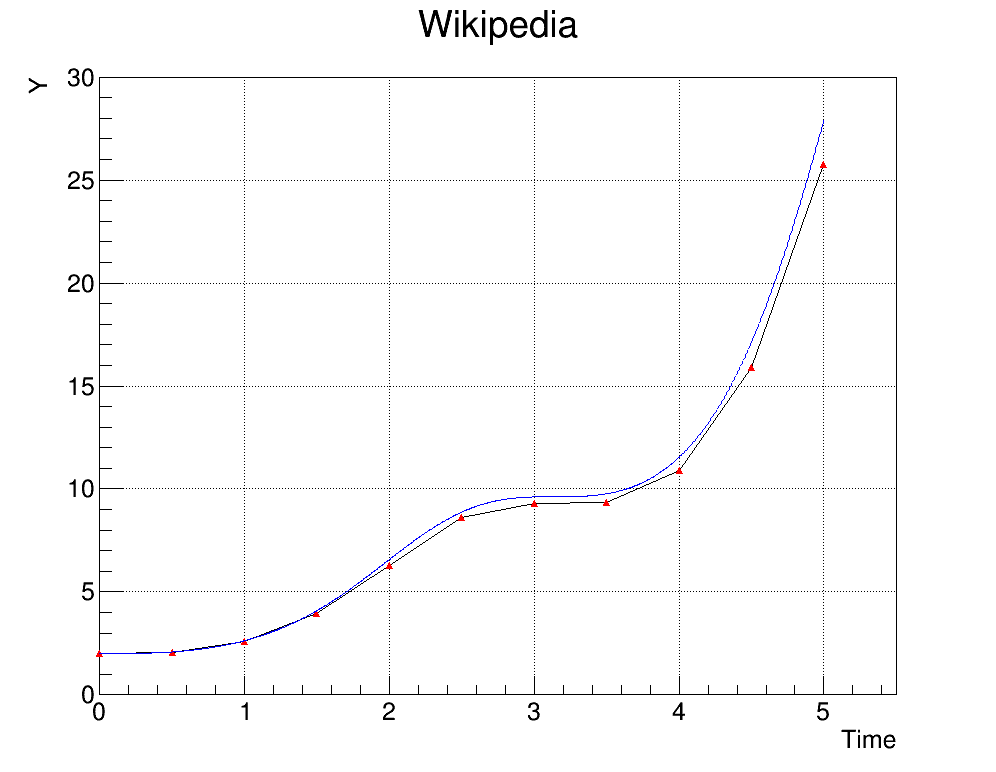

In [11]:
gStyle.SetOptFit(1)
c1.Draw()

if (method==2):
    grr = TGraph(2*nStep-1,tplot,yplot)
else:
    grr = TGraph(nStep,tplot,yplot)
grr.SetMarkerColor(2)
grexact = TGraph(nexact+1,tt,yy)
grexact.SetLineColor(4)

c1.cd()
grr.GetHistogram().SetMaximum(30.0)
grr.GetHistogram().SetMinimum(0.0)
grr.SetMarkerStyle(22)
grr.SetTitle("Wikipedia")
grr.GetXaxis().SetTitle("Time")
grr.GetYaxis().SetTitle("Y")
grr.Draw("APL")
grexact.Draw("L")
c1.Draw()